In [8]:
from captum.attr._core.shapley_value import *
from captum._utils.common import (
    _expand_additional_forward_args,
    _expand_target,
    _format_additional_forward_args,
    _format_output,
    _format_tensor_into_tuples,
    _is_tuple,
    _run_forward,
)
from captum.attr._utils.common import (
    _construct_default_feature_mask,
    _find_output_mode_and_verify,
    _format_input_baseline,
    _tensorize_baseline,
)


class NewSVS(ShapleyValueSampling):
    @log_usage()
    def new_attribute(
        self,
        inputs: TensorOrTupleOfTensorsGeneric,
        baselines: BaselineType = None,
        target: TargetType = None,
        additional_forward_args: Any = None,
        feature_mask: Union[None, TensorOrTupleOfTensorsGeneric] = None,
        n_samples: int = 25,
        perturbations_per_eval: int = 1,
        show_progress: bool = False,
        num_pertub: int = 5,
    ) -> TensorOrTupleOfTensorsGeneric:
        # Keeps track whether original input is a tuple or not before
        # converting it into a tuple.
        is_inputs_tuple = _is_tuple(inputs)
        inputs, baselines = _format_input_baseline(inputs, baselines)
        additional_forward_args = _format_additional_forward_args(
            additional_forward_args
        )
        feature_mask = (
            _format_tensor_into_tuples(feature_mask)
            if feature_mask is not None
            else None
        )
        assert (
            isinstance(perturbations_per_eval, int) and perturbations_per_eval >= 1
        ), "Ablations per evaluation must be at least 1."

        with torch.no_grad():
            baselines = _tensorize_baseline(inputs, baselines)
            num_examples = inputs[0].shape[0]

            if feature_mask is None:
                feature_mask, total_features = _construct_default_feature_mask(inputs)
            else:
                total_features = int(
                    max(torch.max(single_mask).item() for single_mask in feature_mask)
                    + 1
                )

            if show_progress:
                attr_progress = progress(
                    desc=f"{self.get_name()} attribution",
                    total=self._get_n_evaluations(
                        total_features, n_samples, perturbations_per_eval
                    )
                    + 1,  # add 1 for the initial eval
                )
                attr_progress.update(0)

            initial_eval = _run_forward(
                self.forward_func, baselines, target, additional_forward_args
            )

            if show_progress:
                attr_progress.update()

            agg_output_mode = _find_output_mode_and_verify(
                initial_eval, num_examples, perturbations_per_eval, feature_mask
            )

            # Initialize attribution totals and counts
            total_attrib = [
                torch.zeros_like(
                    input[0:1] if agg_output_mode else input, dtype=torch.float
                )
                for input in inputs
            ]

            iter_count = 0
            # Iterate for number of samples, generate a permutation of the features
            # and evalute the incremental increase for each feature.
            for feature_permutation in self.permutation_generator(
                total_features, n_samples
            ):
                iter_count += 1
                prev_results = initial_eval
                for (
                    current_inputs,
                    current_add_args,
                    current_target,
                    current_masks,
                ) in self._perturbation_generator(
                    inputs,
                    additional_forward_args,
                    target,
                    baselines,
                    feature_mask,
                    feature_permutation,
                    perturbations_per_eval,
                    num_perturb=num_pertub,
                ):
                    if sum(torch.sum(mask).item() for mask in current_masks) == 0:
                        warnings.warn(
                            "Feature mask is missing some integers between 0 and "
                            "num_features, for optimal performance, make sure each"
                            " consecutive integer corresponds to a feature."
                        )
                    # modified_eval dimensions: 1D tensor with length
                    # equal to #num_examples * #features in batch
                    modified_eval = _run_forward(
                        self.forward_func,
                        current_inputs,
                        current_target,
                        current_add_args,
                    )
                    if show_progress:
                        attr_progress.update()

                    if agg_output_mode:
                        eval_diff = modified_eval - prev_results
                        prev_results = modified_eval
                    else:
                        all_eval = torch.cat((prev_results, modified_eval), dim=0)
                        eval_diff = all_eval[num_examples:] - all_eval[:-num_examples]
                        prev_results = all_eval[-num_examples:]
                    for j in range(len(total_attrib)):
                        current_eval_diff = eval_diff
                        if not agg_output_mode:
                            # current_eval_diff dimensions:
                            # (#features in batch, #num_examples, 1,.. 1)
                            # (contains 1 more dimension than inputs). This adds extra
                            # dimensions of 1 to make the tensor broadcastable with the
                            # inputs tensor.
                            current_eval_diff = current_eval_diff.reshape(
                                (-1, num_examples) + (len(inputs[j].shape) - 1) * (1,)
                            )
                        total_attrib[j] += (
                            current_eval_diff * current_masks[j].float()
                        ).sum(dim=0)
                        #print(f'current_eval_diff: {current_eval_diff.item()}')
                        #print(total_attrib)

            if show_progress:
                attr_progress.close()

            # Divide total attributions by number of random permutations and return
            # formatted attributions.
            attrib = tuple(
                tensor_attrib_total / iter_count for tensor_attrib_total in total_attrib
            )
            formatted_attr = _format_output(is_inputs_tuple, attrib)
        return formatted_attr


    def _perturbation_generator(
        self,
        inputs: Tuple[Tensor, ...],
        additional_args: Any,
        target: TargetType,
        baselines: Tuple[Tensor, ...],
        input_masks: TensorOrTupleOfTensorsGeneric,
        feature_permutation: Sequence[int],
        perturbations_per_eval: int,
        num_perturb: int = 5,
    ) -> Iterable[Tuple[Tuple[Tensor, ...], Any, TargetType, Tuple[Tensor, ...]]]:
        """
        This method is a generator which yields each perturbation to be evaluated
        including inputs, additional_forward_args, targets, and mask.
        """
        # current_tensors starts at baselines and includes each additional feature as
        # added based on the permutation order.
        current_tensors = baselines
        current_tensors_list = []
        current_mask_list = []

        # Compute repeated additional args and targets
        additional_args_repeated = (
            _expand_additional_forward_args(additional_args, perturbations_per_eval)
            if additional_args is not None
            else None
        )
        target_repeated = _expand_target(target, perturbations_per_eval)

        lower_value = max(0, len(feature_permutation) - num_perturb)
        for i in range(lower_value, len(feature_permutation)):
            current_tensors = tuple(
                current * (~(mask == feature_permutation[i])).to(current.dtype)
                + input * (mask == feature_permutation[i]).to(input.dtype)
                for input, current, mask in zip(inputs, current_tensors, input_masks)
            )
            current_tensors_list.append(current_tensors)
            current_mask_list.append(
                tuple(mask == feature_permutation[i] for mask in input_masks)
            )
            if len(current_tensors_list) == perturbations_per_eval:
                combined_inputs = tuple(
                    torch.cat(aligned_tensors, dim=0)
                    for aligned_tensors in zip(*current_tensors_list)
                )
                combined_masks = tuple(
                    torch.stack(aligned_masks, dim=0)
                    for aligned_masks in zip(*current_mask_list)
                )
                yield (
                    combined_inputs,
                    additional_args_repeated,
                    target_repeated,
                    combined_masks,
                )
                current_tensors_list = []
                current_mask_list = []

        # Create batch with remaining evaluations, may not be a complete batch
        # (= perturbations_per_eval)
        if len(current_tensors_list) != 0:
            additional_args_repeated = (
                _expand_additional_forward_args(
                    additional_args, len(current_tensors_list)
                )
                if additional_args is not None
                else None
            )
            target_repeated = _expand_target(target, len(current_tensors_list))
            combined_inputs = tuple(
                torch.cat(aligned_tensors, dim=0)
                for aligned_tensors in zip(*current_tensors_list)
            )
            combined_masks = tuple(
                torch.stack(aligned_masks, dim=0)
                for aligned_masks in zip(*current_mask_list)
            )
            yield (
                combined_inputs,
                additional_args_repeated,
                target_repeated,
                combined_masks,
            )



New S V S attribution:   0%|          | 0/37 [00:00<?, ?it/s]

current_eval_diff: 6.87
[tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.8700, 0.0000]])]
current_eval_diff: -0.8099999999999996
[tensor([[ 0.0000,  0.0000,  0.0000, -0.8100,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          6.8700,  0.0000]])]
current_eval_diff: -0.39000000000000057
[tensor([[ 0.0000,  0.0000,  0.0000, -0.8100,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000, -0.3900,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          6.8700,  0.0000]])]


New S V S attribution:  19%|█▉        | 7/37 [00:00<00:02, 12.70it/s]

current_eval_diff: 2.790000000000001
[tensor([[ 0.0000,  0.0000,  0.0000, -0.8100,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000, -0.3900,  2.7900,  0.0000,  0.0000,  0.0000,  0.0000,
          6.8700,  0.0000]])]
current_eval_diff: -1.9000000000000004
[tensor([[ 0.0000,  0.0000, -1.9000, -0.8100,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000, -0.3900,  2.7900,  0.0000,  0.0000,  0.0000,  0.0000,
          6.8700,  0.0000]])]
current_eval_diff: -6.66
[tensor([[ 0.0000,  0.0000, -1.9000, -0.8100,  0.0000,  0.0000,  0.0000,  0.0000,
         -6.6600,  0.0000, -0.3900,  2.7900,  0.0000,  0.0000,  0.0000,  0.0000,
          6.8700,  0.0000]])]
current_eval_diff: -3.24
[tensor([[ 0.0000,  0.0000, -1.9000, -0.8100,  0.0000,  0.0000, -3.2400,  0.0000,
         -6.6600,  0.0000, -0.3900,  2.7900,  0.0000,  0.0000,  0.0000,  0.0000,
          6.8700,  0.0000]])]
current_eval_diff: 9.48
[tensor([[ 0.0000,  0.0000, -1.9000, -0.8100,  0.0000,  0.0000, -3.2400,  0.00

New S V S attribution:  30%|██▉       | 11/37 [00:00<00:02, 12.68it/s]

current_eval_diff: -1.53
[tensor([[ 0.0000,  0.0000, -1.9000, -0.8100,  0.0000,  0.0000, -3.2400, -1.5300,
         -6.6600,  0.0000, -0.3900,  2.7900,  2.7700,  0.0000,  9.4800,  0.0000,
          6.8700,  0.0000]])]


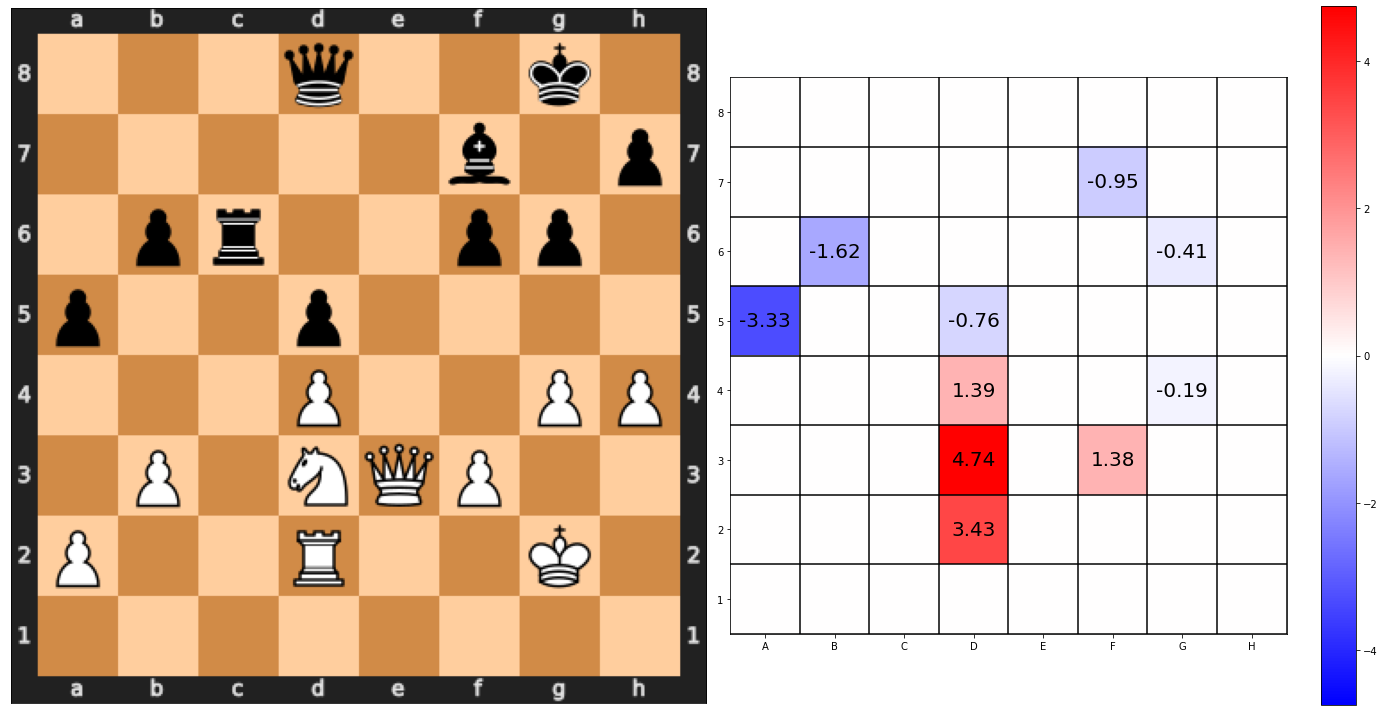

In [7]:

from utils import eval_class
import matplotlib.pyplot as plt
import chess
import numpy as np
from io import BytesIO
from PIL import Image
import cairosvg
import chess
import chess.svg

fen_string = "3q2k1/5b1p/1pr2pp1/p2p4/3P2PP/1P1NQP2/P2R2K1/8 w - - 0 1"
non_king_pieces = ["p", "b", "n", "r", "q"]
perturb_pieces = non_king_pieces
color = None
n_samples = 400
method = 'shapley'

board = chess.Board(fen_string)

eval = eval_class(board, pertub_pieces=perturb_pieces, color=color)

alg_svs = NewSVS(eval)

mat = (
    alg_svs.new_attribute(
        eval.input,
        baselines=0,
        target=0,
        perturbations_per_eval=1,
        n_samples=n_samples,
        show_progress=True,
    )
    .detach()
    .cpu()
    .numpy()
)


board_mat = np.zeros((8, 8))
for i in range(mat.shape[1]):
    board_mat.ravel()[63 - eval.chosen_map_keys[i]] = mat[0, i]
board_mat = np.fliplr(board_mat)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))

max_abs_val = np.abs(board_mat).max()
ax2_plot = ax2.imshow(board_mat, vmin=-max_abs_val, vmax=max_abs_val, cmap="bwr")

ax2.hlines(
    y=np.arange(0, 8) + 0.5,
    xmin=np.full(8, 0) - 0.5,
    xmax=np.full(8, 8) - 0.5,
    color="black",
)
ax2.vlines(
    x=np.arange(0, 8) + 0.5,
    ymin=np.full(8, 0) - 0.5,
    ymax=np.full(8, 8) - 0.5,
    color="black",
)
ax2.set_xticks(list(range(8)))
ax2.set_xticklabels(["A", "B", "C", "D", "E", "F", "G", "H"])
ax2.set_yticks(list(range(8)))
ax2.set_yticklabels(["8", "7", "6", "5", "4", "3", "2", "1"])

#ax2.set_title(f"Method: {method}, Pieces: {include_pieces}, Value: {saliency['value'].item()}")

plt.colorbar(ax2_plot, ax=ax2)

for i in range(board_mat.shape[0]):
    for j in range(board_mat.shape[1]):
        c = board_mat[j, i]
        if c != 0:
            ax2.text(
                i, j, f"{c:.2f}", va="center", ha="center", c="black", fontsize=20
            )

svg = chess.svg.board(board)
img = cairosvg.svg2png(svg)
img = Image.open(BytesIO(img))
ax1_plot = ax1.imshow(img)
ax1.set_xticks([])
ax1.set_yticks([])

plt.tight_layout()

In [19]:
board_mat

array([[ 0.        ,  0.        ,  0.        , -4.17599964,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.83200008,  0.        , -0.82800007],
       [ 0.        , -0.49699998, -2.05999994,  0.        ,  0.        ,
        -0.60300004, -0.40500003,  0.        ],
       [-1.90900004,  0.        ,  0.        , -0.109     ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.29899999,  0.        ,
         0.        ,  0.245     ,  0.        ],
       [ 0.        ,  0.51100004,  0.        ,  1.70299983,  0.71100003,
         0.303     ,  0.        ,  0.        ],
       [ 0.88099992,  0.        ,  0.        ,  0.68699998,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])